In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm # for progress bar
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard
import logging

2023-05-10 23:38:59.862359: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 23:38:59.886770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 23:39:00.227509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Remove prior tensor logs from the log file
#!rm -rf /logs/google

In [2]:
gpus = tf.config.list_physical_devices('GPU')

tf.config.set_visible_devices(gpus[-1], 'GPU')

2023-05-10 23:39:00.798562: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 23:39:00.798784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 23:39:00.814931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
with tf.device('/device:GPU:1'):
    # Reshape image 
    (x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()

    # Divide training dataset into training and validation sets
    x_val = x_train[-2000:,:,:]
    y_val = y_train[-2000:]
    x_train = x_train[:-2000,:,:]
    y_train = y_train[:-2000]
    print(x_train.shape)
    print(y_train.shape)
    print(x_test.shape)
    print(y_test.shape)
    print(x_val.shape)
    print(y_val.shape)

2023-05-10 23:39:00.836424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 23:39:00.836558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 23:39:00.836616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(48000, 32, 32, 3)
(48000, 1)
(10000, 32, 32, 3)
(10000, 1)
(2000, 32, 32, 3)
(2000, 1)


In [4]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool):
    
    path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
    path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
    path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
    
    return tf.concat([path1, path2, path3, path4], axis=3)

In [5]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)
x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(10, activation='softmax')(aux2)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [6]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [7]:
with tf.device('/device:GPU:1'):
      model.compile(optimizer='adam', 
                  loss=[losses.sparse_categorical_crossentropy,
                        losses.sparse_categorical_crossentropy,
                        losses.sparse_categorical_crossentropy],
                  loss_weights=[1, 0.3, 0.3],
                  metrics=['accuracy'])

      log_dir = "logs/google/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
      tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

      # Define the CSVLogger callback
      csv_logger = tf.keras.callbacks.CSVLogger('googletraining.log')

      callbacks = [tensorboard_callback, csv_logger]

      history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=64, epochs=40, callbacks=callbacks)


Epoch 1/40


2023-05-10 23:39:06.279193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-10 23:39:07.460104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-10 23:39:07.537451: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fbc46556010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 23:39:07.537465: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-10 23:39:07.550076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-10 23:39:07.676274: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

750/750 [==============================] - 46s 41ms/step - loss: 3.0953 - dense_4_loss: 1.9518 - dense_1_loss: 1.9121 - dense_3_loss: 1.8995 - dense_4_accuracy: 0.2510 - dense_1_accuracy: 0.2985 - dense_3_accuracy: 0.2892 - val_loss: 2.6126 - val_dense_4_loss: 1.6682 - val_dense_1_loss: 1.5421 - val_dense_3_loss: 1.6059 - val_dense_4_accuracy: 0.3595 - val_dense_1_accuracy: 0.4290 - val_dense_3_accuracy: 0.3960
Epoch 2/40
750/750 [==============================] - 31s 41ms/step - loss: 2.4273 - dense_4_loss: 1.5397 - dense_1_loss: 1.4840 - dense_3_loss: 1.4744 - dense_4_accuracy: 0.4245 - dense_1_accuracy: 0.4574 - dense_3_accuracy: 0.4547 - val_loss: 2.1657 - val_dense_4_loss: 1.3782 - val_dense_1_loss: 1.3030 - val_dense_3_loss: 1.3218 - val_dense_4_accuracy: 0.5030 - val_dense_1_accuracy: 0.5310 - val_dense_3_accuracy: 0.5230
Epoch 3/40
750/750 [==============================] - 31s 41ms/step - loss: 2.0292 - dense_4_loss: 1.2709 - dense_1_loss: 1.2894 - dense_3_loss: 1.2382 - dense

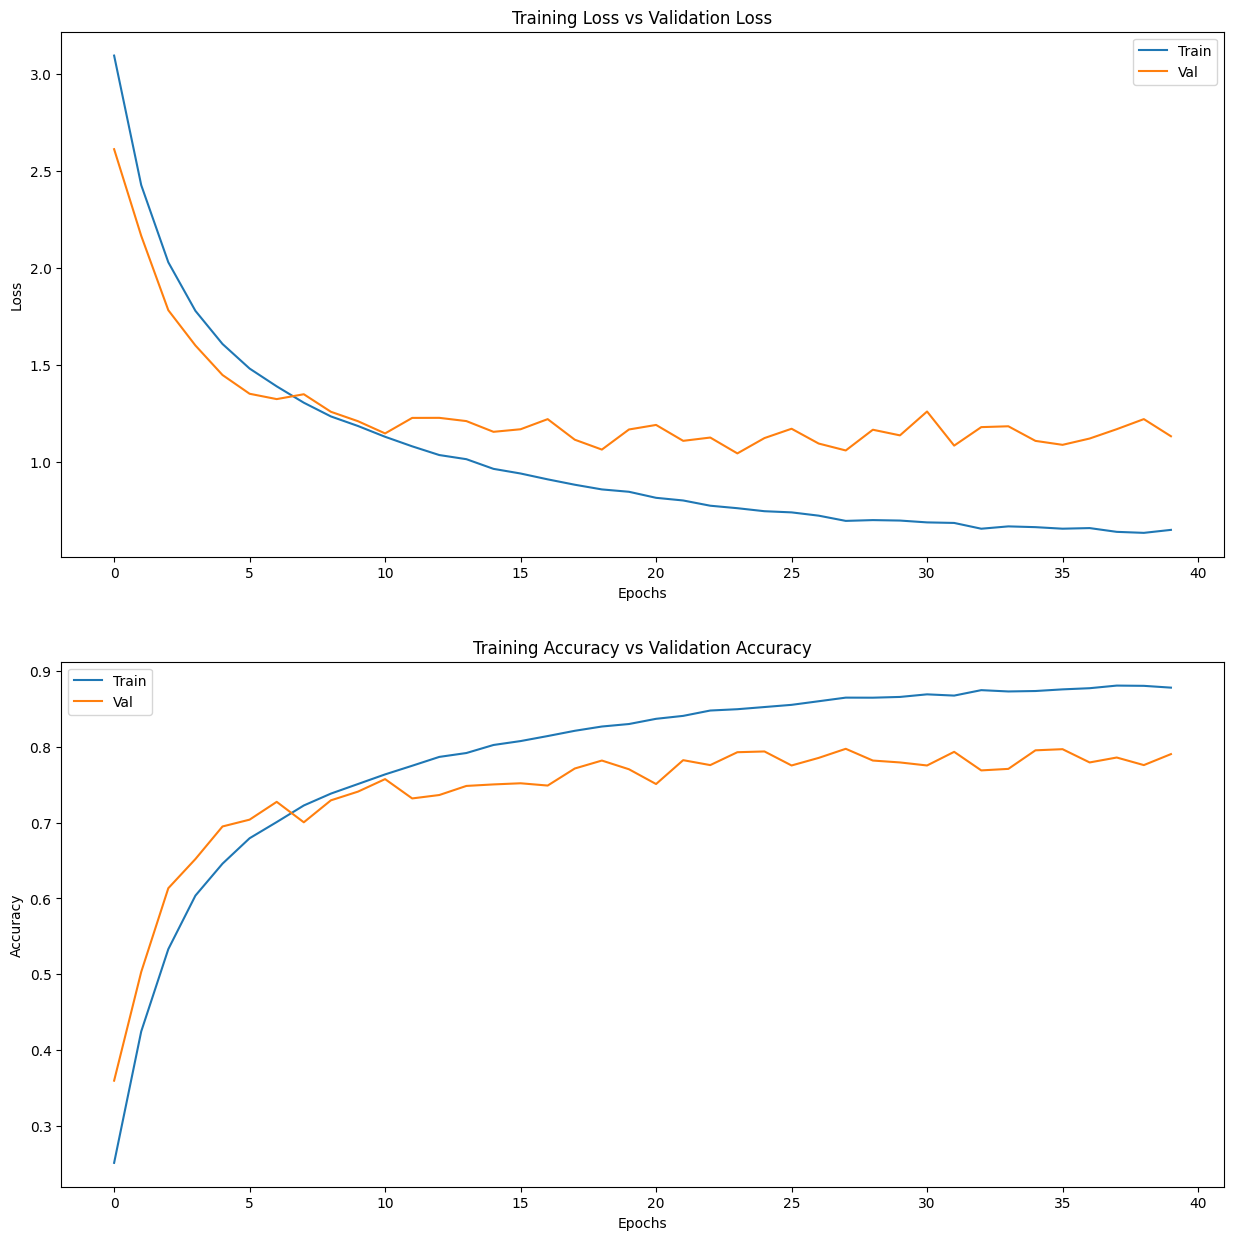

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['dense_4_accuracy'])
axs[1].plot(history.history['val_dense_4_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [9]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 1.1985 - dense_4_loss: 0.7136 - dense_1_loss: 0.8538 - dense_3_loss: 0.7626 - dense_4_accuracy: 0.7794 - dense_1_accuracy: 0.7478 - dense_3_accuracy: 0.7721


[1.198520541191101,
 0.7136045098304749,
 0.8538177013397217,
 0.7625702023506165,
 0.7793999910354614,
 0.7477999925613403,
 0.7720999717712402]

In [10]:
%reload_ext tensorboard
%tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-05-10 23:59:47.544715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/metaverse/miniconda3/envs/mutiah/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/metaverse/miniconda3/envs/mutiah/lib/python3.9/site-packages/tensorboard_data_server/bin/server)
/home/metaverse/miniconda3/envs/mutiah/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/metaverse/miniconda3/envs/mutiah/lib/python3.9/site-packages/tensorboard_data_server/bin/server)
/home/metaverse/miniconda3/envs/mutiah/lib/python3.9/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/metaverse/miniconda3/envs/mutiah/lib/python3.9/site